# SCIENCE

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import os
import glob
import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
from astropy.io import fits

filter = ['Ha', 'Hb', 'g', 'r', 'i']
file_paths = {f: f'data/cleaned_calibrated/{f}_calibrated.fit' for f in filter}

filter_cmap = {
    'Ha': 'gnuplot2',
    'Hb': 'pink',
    'g': 'bone',
    'r': 'hot',
    'i': 'copper'
}

image = {}

for f in filter:
    with fits.open(file_paths[f]) as hdul:
        #hdul.info()
        image[f] = hdul[0].data


## Transformation to wcs

In [38]:
# Stars recognized by ASTROMETRY.NET  https://nova.astrometry.net/upload
# x,y coordinates on detector and ra dec coordinates necessary to create the map X,Y -> RA,Dec

stars_astrometry = []

with fits.open("data/astrometry.fit") as hdul:
    if len(hdul) > 1:
        table_hdu = hdul[1]  

        if table_hdu.data.ndim == 1:
            table = np.stack(table_hdu.data)

        for row in table:
            stars_astrometry.append({'ra': row[0], 'dec': row[1], 'x': row[2], 'y': row[3]})

In [40]:
# TRANSFORM x,y in ra,dec

# Extract coordinates
x = np.array([star['x'] for star in stars_astrometry])
y = np.array([star['y'] for star in stars_astrometry])
ra = np.array([star['ra'] for star in stars_astrometry])
dec = np.array([star['dec'] for star in stars_astrometry])

# Define linear transformation model
def ra_model(coords, a0, a1, a2):
    x, y = coords
    return a0 + a1 * x + a2 * y

def dec_model(coords, b0, b1, b2):
    x, y = coords
    return b0 + b1 * x + b2 * y

from scipy.optimize import curve_fit
# Fit RA model
params_ra, _ = curve_fit(ra_model, (x, y), ra)
# Fit Dec model
params_dec, _ = curve_fit(dec_model, (x, y), dec)

# Transformation function
def xy_to_radec(x, y):
    """
    Transform grid of (x, y) to (RA, Dec) coordinates.
    """
    ra = params_ra[0] + params_ra[1] * x + params_ra[2] * y
    dec = params_dec[0] + params_dec[1] * x + params_dec[2] * y
    return ra, dec

def radec_to_xy(ra, dec):
    A = np.array([[params_ra[1], params_ra[2]],
                  [params_dec[1], params_dec[2]]])
    b = np.array([ra - params_ra[0], dec - params_dec[0]])
    # Solve the linear system A * [x, y] = b
    x, y = np.linalg.solve(A, b)
    return x, y



In [44]:
# PLOT IMAGE WITH RA,DEC GRID

ny, nx = image[filter[0]].shape

RA_min = xy_to_radec(nx, ny)[0]
RA_max = xy_to_radec(0, 0)[0]
Dec_min = xy_to_radec(nx, 0)[1]
Dec_max = xy_to_radec(0, nx)[1]

ra_range = np.linspace(RA_min, RA_max, 20)  # Example RA range
dec_range = np.linspace(Dec_min, Dec_max, 20)     # Example Dec range

# Grid of RA and Dec for plotting
ra_grid = []
dec_grid = []

# Collect RA constant grid lines
for ra in ra_range:
    decs = np.linspace(dec_range[0], dec_range[-1], 100)
    ras = np.full_like(decs, ra)
    ra_grid.append((ras, decs))

# Collect Dec constant grid lines
for dec in dec_range:
    ras = np.linspace(ra_range[0], ra_range[-1], 100)
    decs = np.full_like(ras, dec)
    dec_grid.append((ras, decs))

# Transform grid lines to pixel coordinates (x, y)
grid_lines_x = []
grid_lines_y = []

for ras, decs in ra_grid + dec_grid:
    x, y = radec_to_xy(ras, decs)
    grid_lines_x.append(x)
    grid_lines_y.append(y)

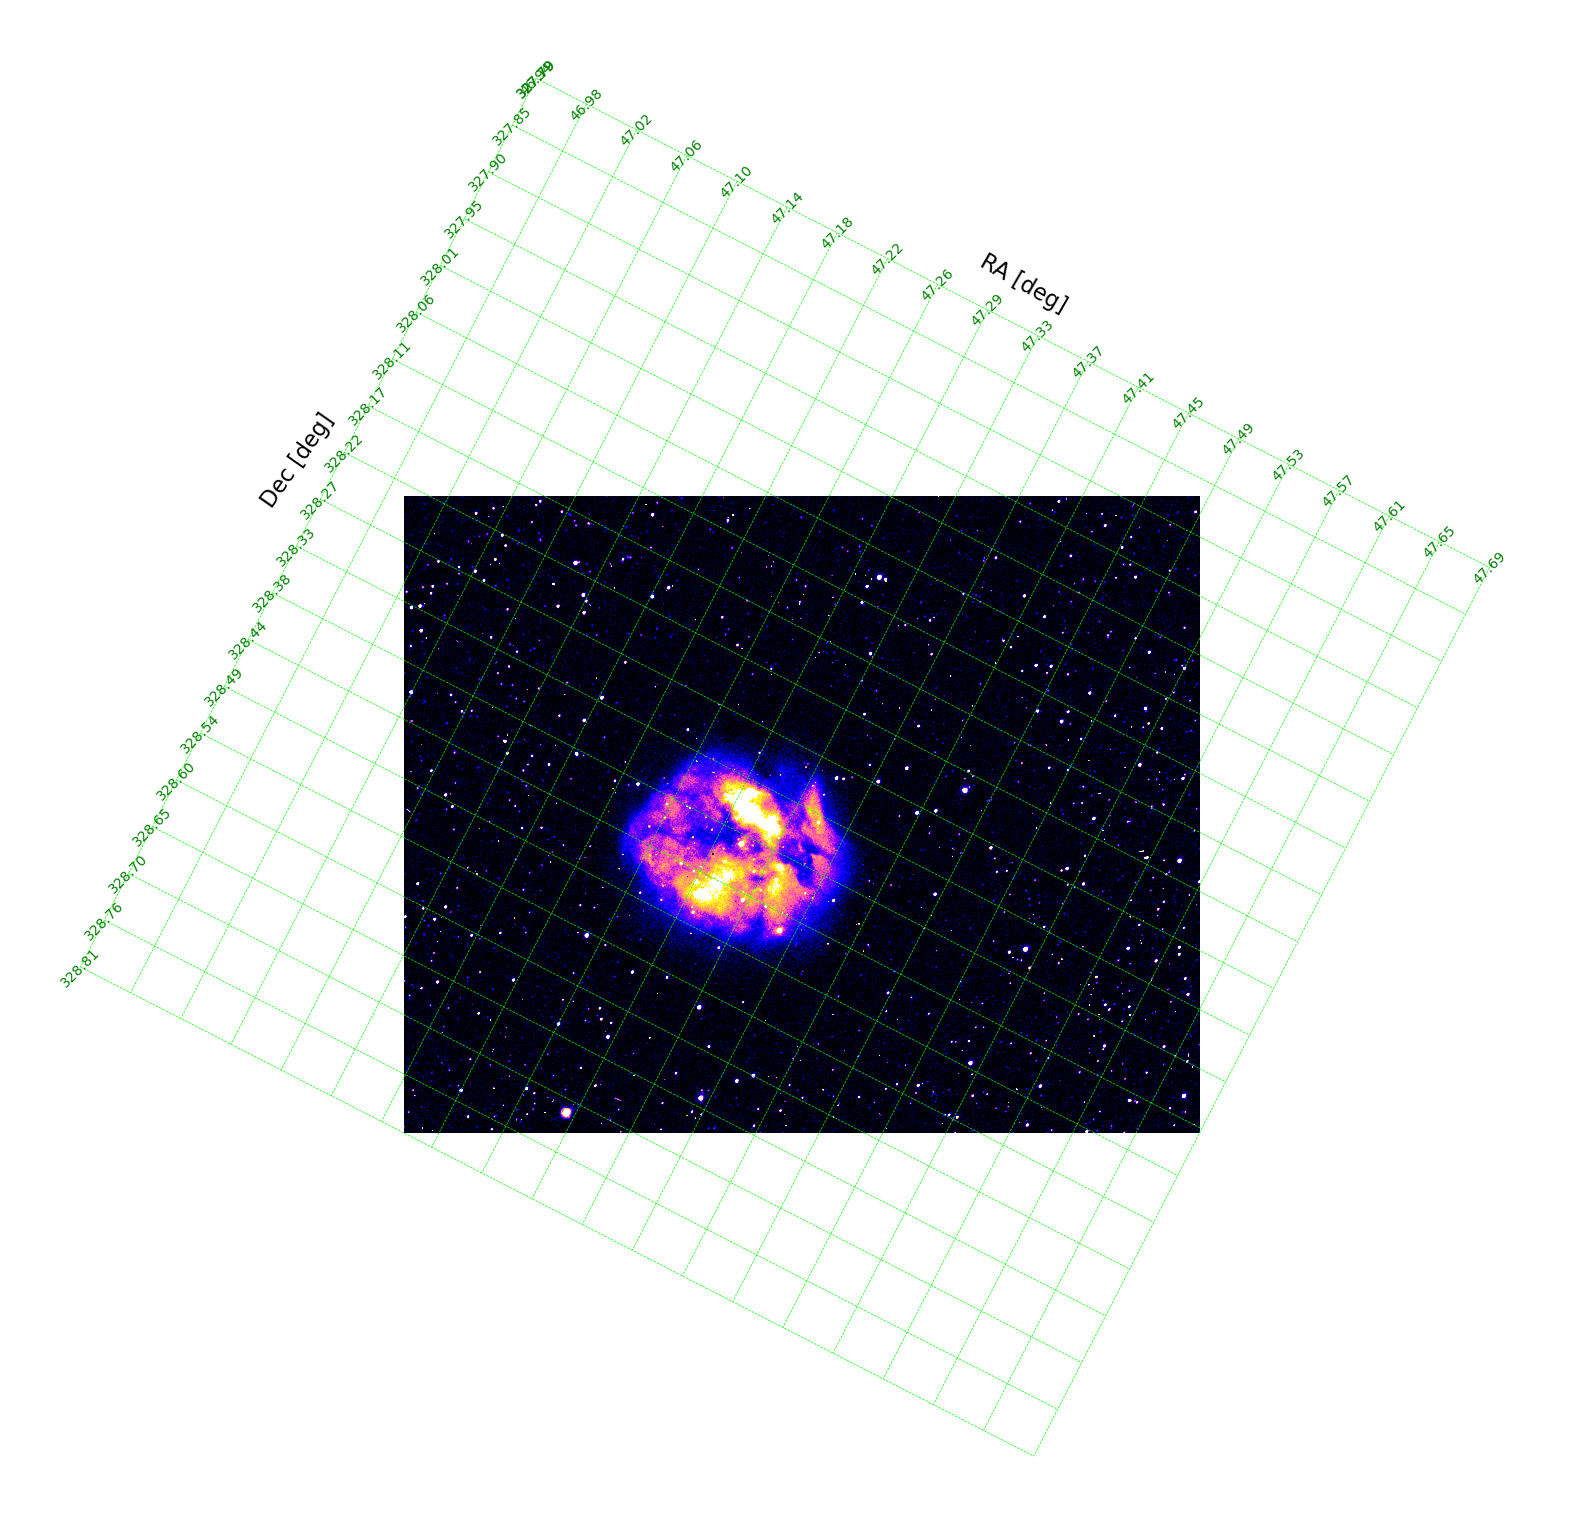

In [57]:
fig, axes = plt.subplots(figsize=(20,20))
plt.imshow(image['Ha'], clim=[0,np.quantile(image['Ha'], 0.99)], cmap=filter_cmap['Ha'], origin='lower')



for x, y in zip(grid_lines_x, grid_lines_y):

    plt.plot(y, x, color='lime', linestyle='--', linewidth=0.5)

# Annotate RA where RA changes (only for RA grid lines)
last_ra = None  # Initialize last RA
for i in range(len(grid_lines_x)):
    # Get RA and Dec for the start of the current line
    ra_start, dec_start = xy_to_radec(grid_lines_x[i][0], grid_lines_y[i][0]) 

    # Annotate only if RA has changed
    if last_ra is None or ra_start != last_ra:
        last_ra = ra_start  # Update last RA value
        if i != len(grid_lines_x):
            plt.text(grid_lines_y[i][0], grid_lines_x[i][0], f'{ra_start:.2f}', color='green', 
                     fontsize=10, rotation=45, ha='center', va='center')
        

# Annotate Dec where Dec changes (only for Dec grid lines)
last_dec = None  # Initialize last Dec
for i in range(len(grid_lines_y)):
    # Get RA and Dec for the start of the current line
    ra_start, dec_start = xy_to_radec(grid_lines_x[i][0], grid_lines_y[i][0]) 

    # Annotate only if Dec has changed
    if last_dec is None or dec_start != last_dec:
        if i != len(grid_lines_y):
            plt.text(grid_lines_y[i][0], grid_lines_x[i][0], f'{dec_start:.2f}', color='green', 
                     fontsize=10, rotation=45, ha='center', va='center')
        last_dec = dec_start  # Update last Dec value

plt.text(-600,3800, "Dec [deg]", color='black', fontsize=16, rotation=55,
         ha='center', va='center')

plt.text(3500,4800, "RA [deg]", color='black', fontsize=16, rotation=-30,
         ha='center', va='center')

plt.axis('off')
plt.show()



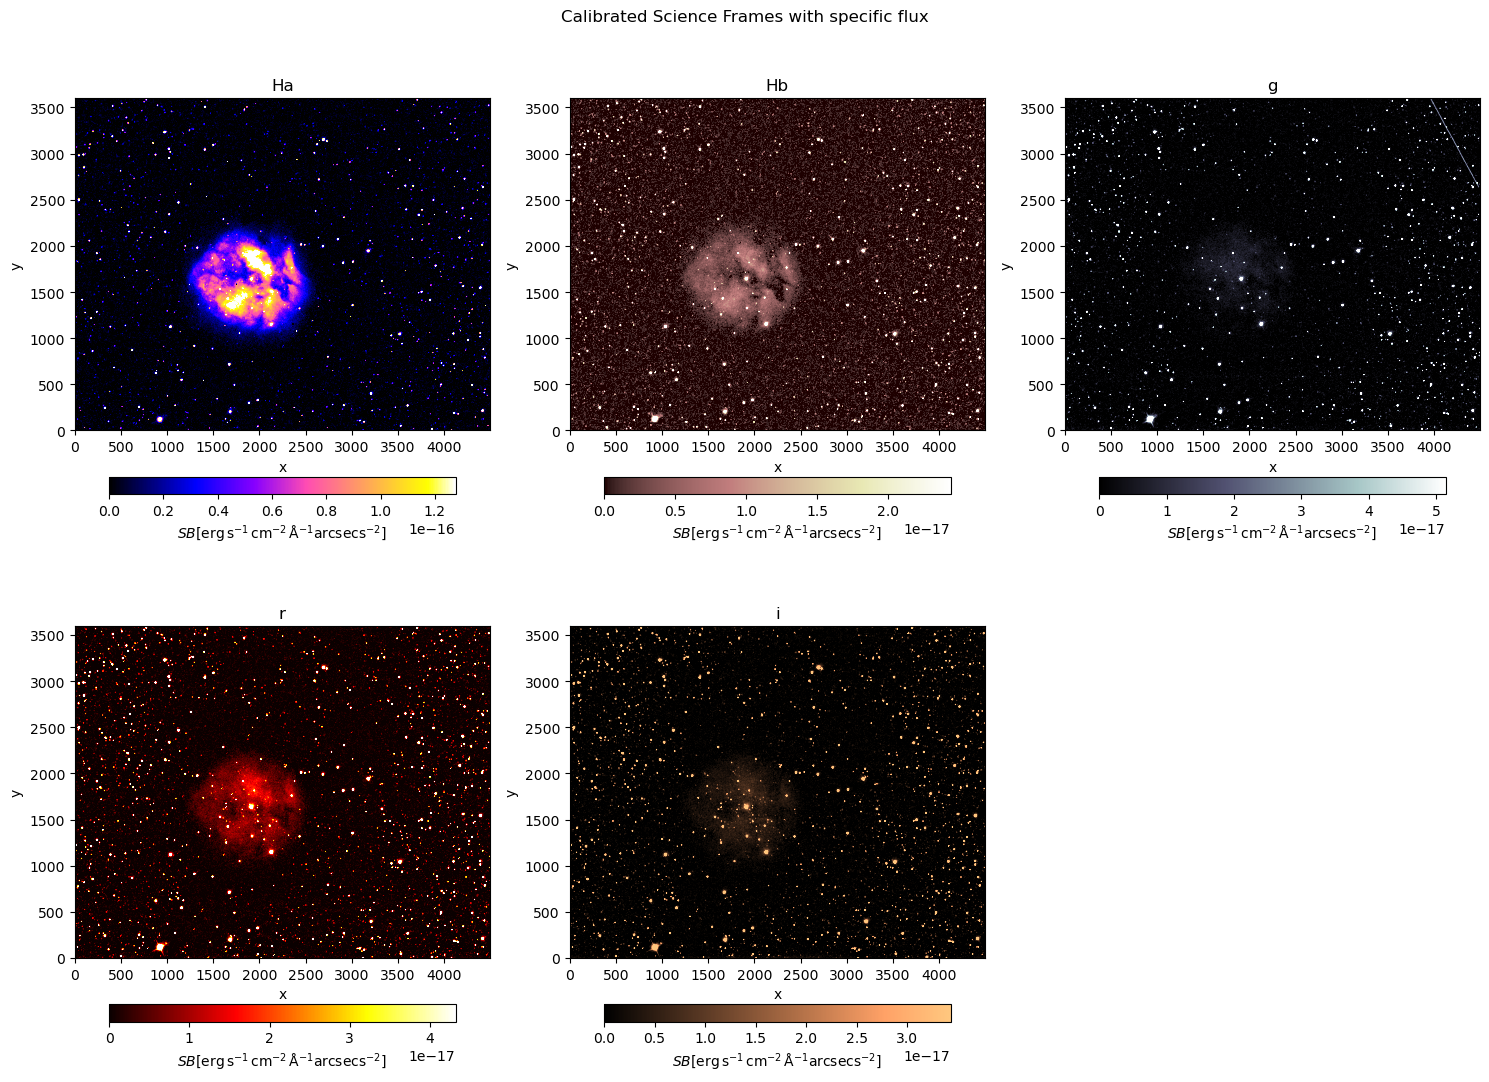

In [59]:
fig, axes = plt.subplots(2, 3, figsize=(15, 11))
fig.suptitle("Calibrated Science Frames with specific flux")
axes = axes.flatten()

ny,nx = image['Ha'].shape

for i, f in enumerate(filter):
    im = axes[i].imshow(image[f], clim=[0,np.quantile(image[f], 0.99)], cmap=filter_cmap[f], origin='lower')
    plt.colorbar(im, ax=axes[i], location='bottom', fraction=0.0375, pad=0.1,
                 label="$SB_\\lambda [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, \u00c5^{-1} arcsecs^{-2}}]$")
    axes[i].set_title(f)
    axes[i].set_xlabel("x")
    axes[i].set_ylabel("y")
    
axes[-1].axis('off')

plt.tight_layout()
plt.show()


## Error extimation

Easiest way to extimate the error is to take for each frame the histogram of the values in each pixel. 

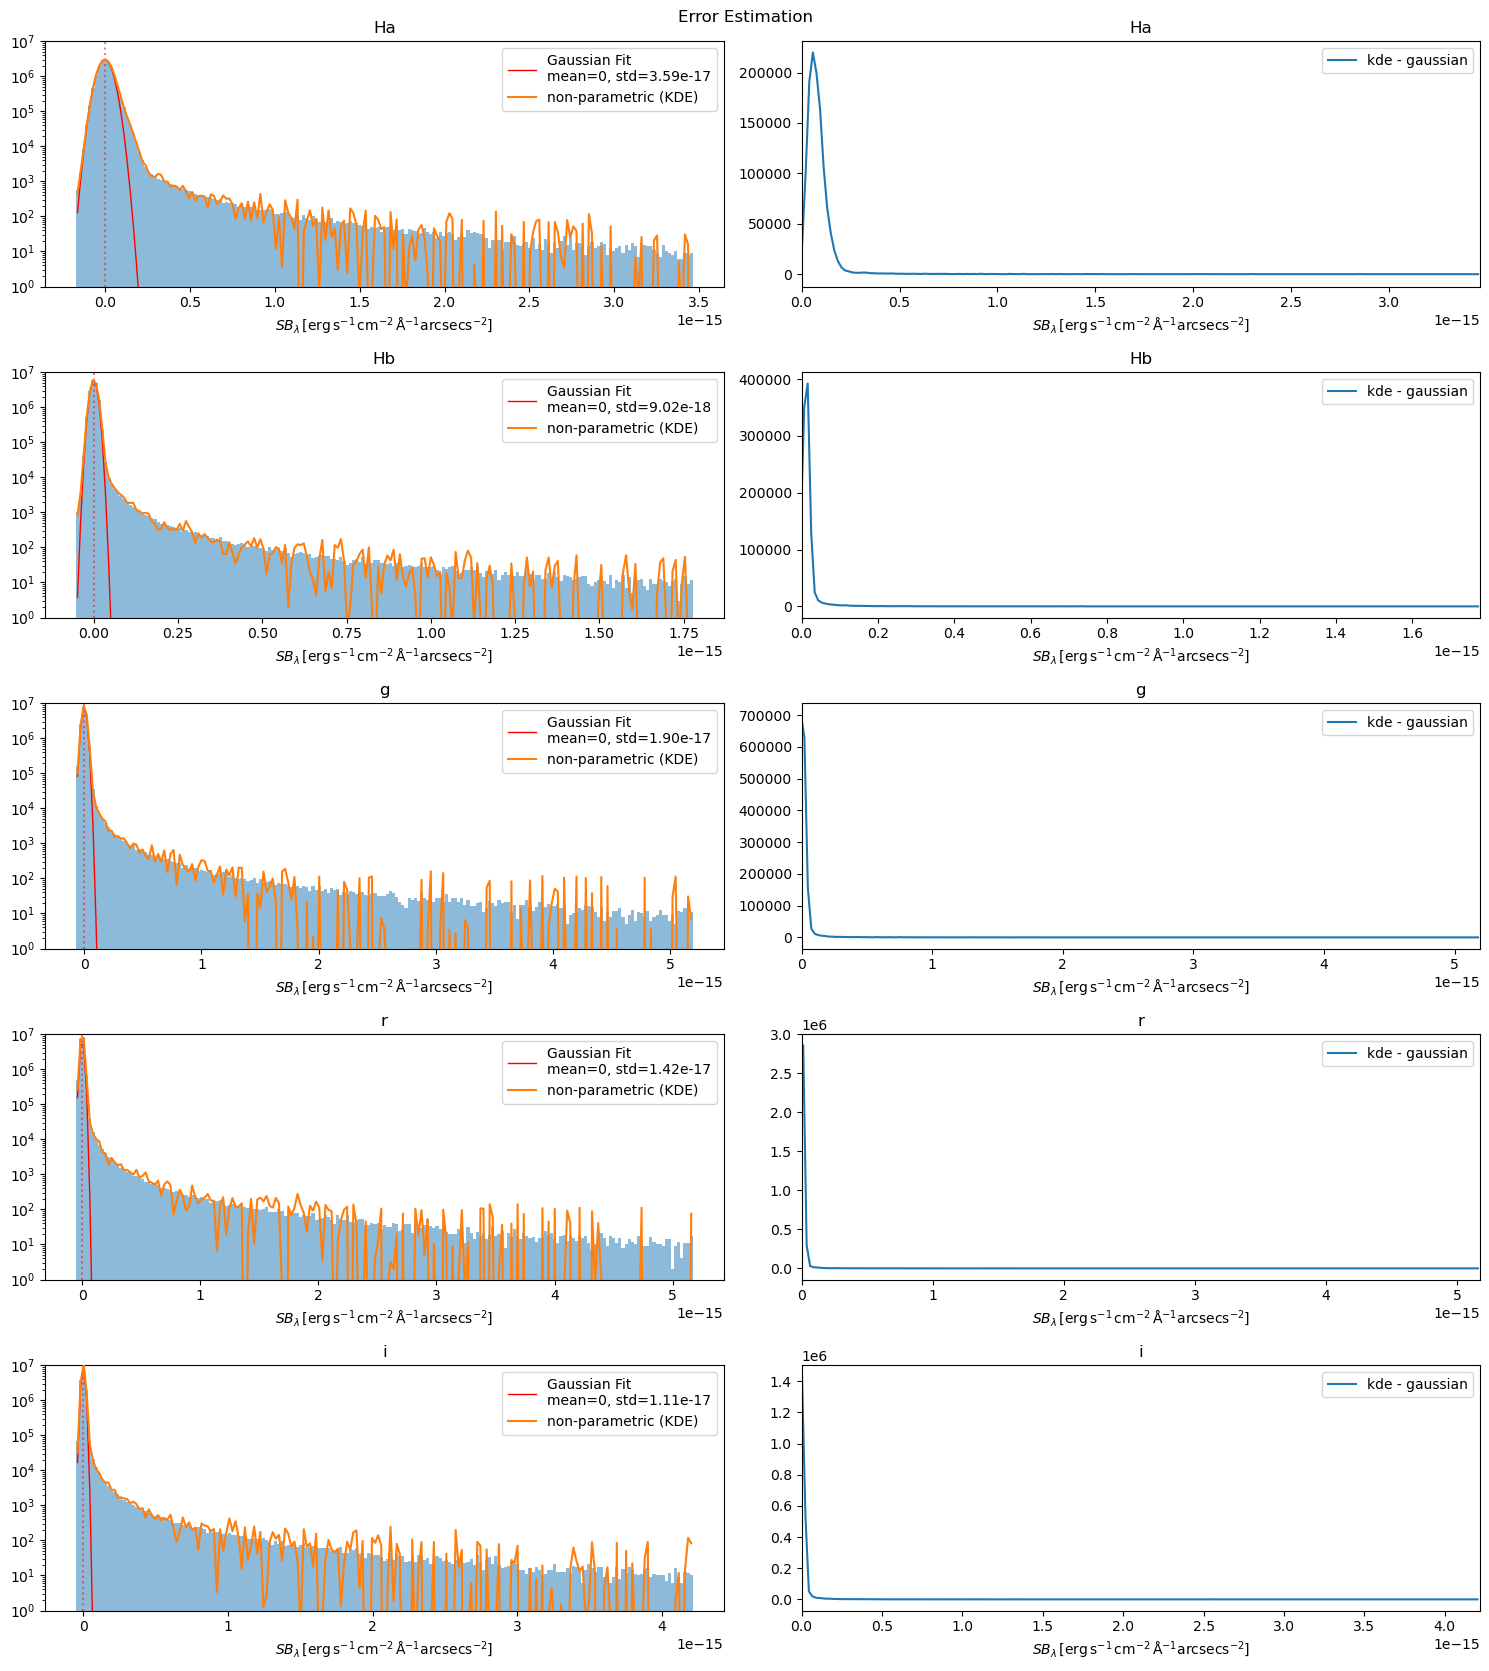

In [35]:
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

fig, ax = plt.subplots(5,2,figsize=(15, 17))
fig.suptitle("Error Estimation")

sigma = {}

for i, f in enumerate(filter):

    flattened_image = image[f].flatten() 

    lower_threshold = np.quantile(flattened_image, 0.0001)
    upper_threshold = np.quantile(flattened_image, 0.9999)
    flattened_image = flattened_image[(flattened_image >= lower_threshold) & (flattened_image <= upper_threshold)]
    
    bin_edges = np.linspace(min(flattened_image),max(flattened_image), 200)

    hist, bins, _  = ax[i,0].hist(flattened_image, bins=bin_edges, alpha=0.5)  
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Fit a Gaussian to the NEGATIVE data only
    flattened_image_negative = flattened_image[flattened_image<0]
    mean, std = norm.fit(np.concatenate((flattened_image_negative,-flattened_image_negative)))
    sigma[f] = std

    normalization = max(hist) * (std*np.sqrt(2*np.pi))
    gaussian_curve = norm.pdf(bin_centers, mean, std) * normalization
    ax[i,0].plot(bin_centers, gaussian_curve, label=f"Gaussian Fit\nmean=0, std={std:.2e}", color='red', lw=1)
    ax[i,0].axvline(x=0,linestyle=':',c='r',alpha=0.5)
    
    # Kernel Density Estimation for the full distribution    
    kde = KernelDensity(bandwidth=0.3e-17, kernel='gaussian')
    flattened_image_small = np.random.choice(flattened_image, size=500000, replace=False)
    kde.fit(flattened_image_small[:, None])
    dens_kde = np.exp(kde.score_samples(bin_centers[:, None]))
    kde_normalized = dens_kde / dens_kde.sum() * hist.sum()
    ax[i,0].plot(bin_centers, kde_normalized, '-', color='C1', zorder=3,label="non-parametric (KDE)")

    ax[i,0].set_ylim(1,1e7)
    ax[i,0].set_yscale("log")
    
    ax[i,0].set_title(f)
    ax[i,0].set_xlabel("$SB_\\lambda \\, [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, \u00c5^{-1} arcsecs^{-2}}]$")
    ax[i,0].legend()
    
    # Distribution of photon from astrophysical sources only (stars and nebula)
    ax[i,1].plot(bin_centers,kde_normalized-gaussian_curve, label = "kde - gaussian")

    ax[i,1].set_title(f)
    ax[i,1].set_xlim(0,upper_threshold)
    ax[i,1].set_xlabel("$SB_\\lambda \\, [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, \u00c5^{-1} arcsecs^{-2}}]$")
    ax[i,1].legend()

plt.tight_layout()
plt.show()


In [36]:
print(sigma)

{'Ha': 3.59097474793571e-17, 'Hb': 9.024845611116972e-18, 'g': 1.8974945529413438e-17, 'r': 1.4205667399553556e-17, 'i': 1.1146923182763999e-17}


***Radiative transfer equation for optically thin sphere***:

$$dI = -I\alpha ds + j ds$$

For an optically thin spherical cloud (case B recombination: the cloud is optically thick only for Lyman continuum photons, but optically thin for all other transitions, like H$\alpha$ or H$\beta$):

$$SB(r) = \int j  ds = 2 \int_{\arcsin(r/R_\text{cloud})}^{\pi/2}   j R_\text{cloud}\sin(\theta)d\theta = 2 j R_\text{cloud} \sqrt{1-(\tfrac{r}{R_\text{cloud}})^2}$$

where $r = R_{cloud} sin(\theta)$ is the projected radius in the sky. 

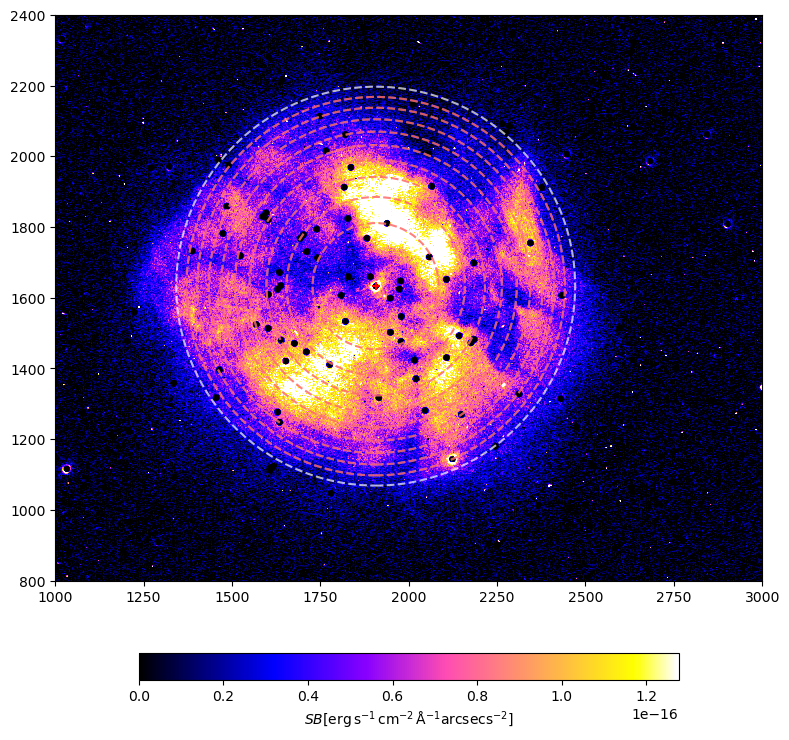

In [74]:
fig, ax = plt.subplots(figsize=(8, 8))
#fig.suptitle("Calibrated Science Frames with specific flux")

# Mask stars

masked_image = np.copy(image['Ha'])  

mask_radius = 10  # as found in calibration

for star in stars_astrometry:
    if 1000 < star['x'] < 3000 and 800 < star['y'] < 2400:
        y, x = np.ogrid[:masked_image.shape[0], :masked_image.shape[1]] # circular aperture mask around the star
        mask = (x - star['x'])**2 + (y - star['y'])**2 <= mask_radius**2
        masked_image[mask] = 0 # np.nan


im = ax.imshow(masked_image, clim=[0,np.quantile(image['Ha'], 0.99)], cmap=filter_cmap['Ha'] , origin='lower')
plt.colorbar(im, ax=ax, location='bottom', fraction=0.0375, pad=0.1, label="$SB  [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, \u00c5^{-1} arcsecs^{-2}}]$")

# Define the center of the annuli (coordinates of the central star, in pixels)
#center_x, center_y = 910, 830
# Define the center of the annuli (coordinates of the central star, in pixels)
# Central star is BD+46 3474B (328.370134,47.266320) https://simbad.u-strasbg.fr/simbad/sim-coo?&Coord=328.375681513405d47.263674788998d&CooFrame=FK5&Radius=2&Radius.unit=arcmin
center_x, center_y = radec_to_xy(328.370134,47.266320) 
plt.scatter(center_x, center_y,marker='+',c='red')
 
# Define the inner and outer radii for the circular annuli such that each annulus contains the same number of pixels
num_annuli = 10
N = 100000
R_int = [0.1]
R_ext = []
# Loop to compute the outer radii so that each annulus has the same number of pixels
for i in range(num_annuli):
    # Compute the area needed for this annulus
    r_ext = np.sqrt(N/np.pi + R_int[-1]**2)  # Use the previous outer radius to define the next outer radius
    R_ext.append(r_ext)
    R_int.append(r_ext)

# Generate the list of annuli radii as tuples of inner and outer radii
annuli_radii = [(R_int[i], R_ext[i]) for i in range(num_annuli)]  

from matplotlib.patches import Circle

for inner_r, outer_r in annuli_radii:
    # Draw outer boundary
    circle_outer = Circle((center_x, center_y), outer_r, edgecolor='white', facecolor='none', 
                           linestyle='--', linewidth=1.5, alpha=0.7)
    ax.add_patch(circle_outer)
    # Draw inner boundary
    circle_inner = Circle((center_x, center_y), inner_r, edgecolor='red', facecolor='none', 
                           linestyle='--', linewidth=1.5, alpha=0.5)
    ax.add_patch(circle_inner)

# Average surface brightness in each annulus
from photutils.aperture import CircularAnnulus, aperture_photometry

average_surface_brightness = []
sigma_surface_brightness = []

for inner_r, outer_r in annuli_radii:

    annulus = CircularAnnulus((center_x, center_y), r_in=inner_r, r_out=outer_r)
    
    phot = aperture_photometry(masked_image, annulus, error = np.full(masked_image.shape, sigma[f]))
    annulus_flux = phot['aperture_sum'][0]
    annulus_flux_err = phot['aperture_sum_err'][0]
    
    # Area of the annular region: A = π * (R_outer^2 - R_inner^2)  # number of pixels????????
    area_annulus = np.pi * (outer_r**2 - inner_r**2)
    
    avg_surface_brightness = annulus_flux / area_annulus
    average_surface_brightness.append(avg_surface_brightness)

    error_surface_brightness = annulus_flux_err / area_annulus
    # error propagation for sigma
    # SB_annulus = sum(SB_pixel)/A
    # sigma_SB_annulus = sigma_pixel/A * sqrt(sum(SB_pixel^2))

    #sum_pixel_flux_squared = aperture_photometry(masked_image**2, annulus, error = np.full(masked_image.shape, sigma[f]))['aperture_sum'][0]
    #err = np.sqrt(sum_pixel_flux_squared)*sigma[f]/area_annulus
    sigma_surface_brightness.append(annulus_flux_err/area_annulus)


ax.set_xlim(1000,3000)
ax.set_ylim(800,2400)

plt.tight_layout()
plt.show()


In [54]:
print(sigma_surface_brightness)
#print(sigma_surface_brightness)
#??????????????????????

[3.524966616046761e-20, 3.52496661604676e-20, 3.524966616046761e-20, 3.5249666160467595e-20, 3.5249666160467613e-20, 3.524966616046758e-20, 3.5249666160467613e-20, 3.5249666160467595e-20, 3.5249666160467625e-20, 3.524966616046764e-20]


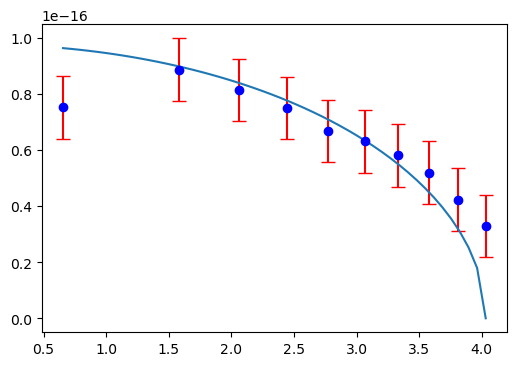

In [75]:
fig,ax = plt.subplots(figsize=(6,4))

angular_size_pixel_TOBI_arcmin = 0.44 / 60 # arcmin per pixel

theta_r = np.array([(inner_r + outer_r) / 2 for inner_r, outer_r in annuli_radii]) * angular_size_pixel_TOBI_arcmin

sigma_surface_brightness = np.full(len(average_surface_brightness), sigma[f])

plt.errorbar(theta_r, average_surface_brightness, yerr=sigma_surface_brightness, fmt='o', color='blue', 
             ecolor='red', capsize=5, linestyle='None')

# K = 2j R_cloud
# this parameter has to be fitted, with assumptions of optically thin homogeneous spherical cloud (uniform j)
from scipy.optimize import curve_fit

def model(theta, K, theta_max):
    return K * np.sqrt(1 - (theta / theta_max) ** 2)

# Fit the curve to the data
theta_max = max(theta_r) 
popt, pcov = curve_fit(lambda theta, K: model(theta, K, theta_max), 
                       theta_r[theta_r>1], np.array(average_surface_brightness)[theta_r>1], sigma=sigma_surface_brightness[theta_r>1])

# popt contains the fitted parameters (in this case, K)
K_fit = popt[0]

theta_grid = np.linspace(min(theta_r),max(theta_r))
plt.plot(theta_grid, K_fit * np.sqrt(1-(theta_grid/max(theta_r))**2))





plt.show()


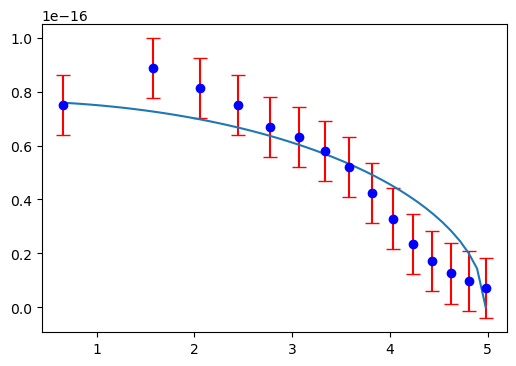

In [71]:
fig,ax = plt.subplots(figsize=(6,4))

angular_size_pixel_TOBI_arcmin = 0.44 / 60 # arcmin per pixel

theta_r = np.array([(inner_r + outer_r) / 2 for inner_r, outer_r in annuli_radii]) * angular_size_pixel_TOBI_arcmin

sigma_surface_brightness = np.full(len(average_surface_brightness), sigma[f])

plt.errorbar(theta_r, average_surface_brightness, yerr=sigma_surface_brightness, fmt='o', color='blue', 
             ecolor='red', capsize=5, linestyle='None')

# K = 2j R_cloud
# this parameter has to be fitted, with assumptions of optically thin homogeneous spherical cloud (uniform j)
from scipy.optimize import curve_fit

def model(theta, K, theta_max):
    return K * np.sqrt(1 - (theta / theta_max) ** 2)

# Fit the curve to the data
theta_max = max(theta_r) #
popt, pcov = curve_fit(lambda theta, K: model(theta, K, theta_max), theta_r, average_surface_brightness, sigma=sigma_surface_brightness)

# popt contains the fitted parameters (in this case, K)
K_fit = popt[0]

theta_grid = np.linspace(min(theta_r),max(theta_r))
plt.plot(theta_grid, K_fit * np.sqrt(1-(theta_grid/max(theta_r))**2))

***Calzetti***

Absorption: 

$$I_{\text{obs,}\lambda} = I_{\text{int,}\lambda} e^{-\tau_\lambda}$$  for absorption only

$$\tau_\lambda = \int \alpha_\lambda ds = \int n_\text{dust}\sigma_\lambda ds = \sigma_\lambda \frac{n_\text{dust}}{n_\text{gas}} \int n_\text{gas}ds$$

In Calzetti notation:

$$\tau_\lambda = \frac{A_{\lambda}}{1.086}=\frac{k(\lambda)E(B-V)}{1.086}$$

Full radiative transfer equation for both emission and absorption:

$$I_\lambda(\tau_\lambda) = I_{0,\lambda}e^{-\tau_\lambda} + \int_0^{\tau_\nu} e^{-(\tau_\nu-\tau_\nu')}S_\lambda(\tau_\lambda')d\tau'_\lambda$$

$S_\lambda$ is the source function and is NOT a black body in this case: actually we are trating the gas + dust cloud as if it was made of only one kind of particle with emissivity the one of the gas and absorption entirely due to gas. Being that 

# BALMER DECREMENT

$$L_{obs}(\lambda) = L_{int}(\lambda)10^{-0.4A_\lambda} = L_{int}(\lambda)10^{-0.4k(\lambda)E(B-V)}$$

Reddening: $E(B-V) = (B-V)_{obs}-(B-V)_{int}$

The relationship between the nebular emission-line color excess and the Balmer decrement is given by:

$$E(B - V) = \frac{E(\mathrm{H}\beta - \mathrm{H}\alpha)}{k(\lambda_{\mathrm{H}\beta}) - k(\lambda_{\mathrm{H}\alpha})} = \frac{2.5}{k(\lambda_{\mathrm{H}\beta}) - k(\lambda_{\mathrm{H}\alpha})} \log_{10} \left[ \frac{(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{obs}}}{(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{int}}} \right]$$

where $(k(\lambda_{\mathrm{H}\beta}))$ and $(k(\lambda_{\mathrm{H}\alpha}))$ are the reddening curves evaluated at $H\beta$ and $H\alpha$ wavelengths, respectively. The factor $E(\mathrm{H}\beta - \mathrm{H}\alpha)$ is analogous to the color excess but defined for $H\beta$ and $H\alpha$ instead of the B and V bands. Then, $(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{obs}}$ is the observed Balmer decrement, and $(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{int}}$ is the intrinsic or unreddened Balmer decrement, which is calculated theoretically.

The intrinsic Balmer decrement remains roughly constant for typical gas conditions in star-forming galaxies (see Osterbrock 1989). In our analysis, we assume the value of $(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{int}} = 2.86$, corresponding to a temperature $T = 10^4 \, \mathrm{K}$ and an electron density $n_e = 10^2 \, \mathrm{cm}^{-3}$ for Case B recombination (Osterbrock 1989). This choice is standard for star-forming galaxies in the literature. Thus, the nebular color excess is given by the following equation:

$$E(B - V) = 1.97 \log_{10} \left( \frac{(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{obs}}}{2.86} \right)$$

### Case B Recombination:

***Lyman Continuum Photons are Reabsorbed***:
When a hydrogen atom recombines with an electron and transitions to the n=1 ground state, it emits a photon in the Lyman series (e.g., Lyman-α). Under Case B, these Lyman photons are absorbed and reprocessed within the gas, instead of escaping.
This reabsorption occurs because the gas is dense enough to be optically thick to ultraviolet photons in the Lyman series.

***Other Transitions are Optically Thin***:
Photons from transitions to levels n>1n (e.g., Hα from n=3→2) can escape the nebula without significant reabsorption.
This results in the prominence of Balmer, Paschen, and other series of hydrogen emission lines in the spectrum.

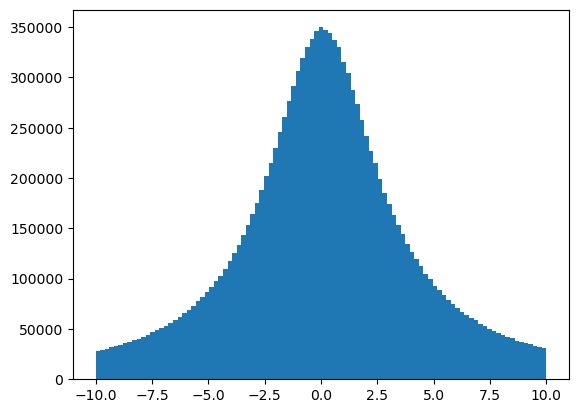

In [8]:
balmer_ratio = images_calib['Ha']/images_calib['Hb']
balmer_ratio_flat = balmer_ratio.flatten()
plt.hist(balmer_ratio_flat,bins=np.linspace(-10,10,100))
plt.show()


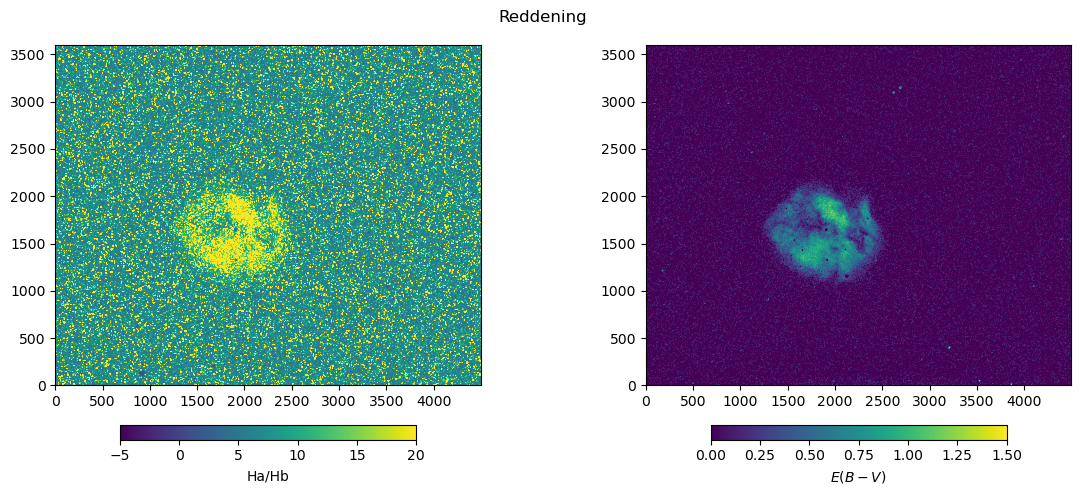

In [15]:
# map of the reddening factor over the nebula

ratio = images_calib['Ha']/images_calib['Hb']
ratio = np.where(ratio>0,ratio,2.86)
E_B_V = 1.97*np.log10(ratio/2.86)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Reddening")

im1 = axes[0].imshow(ratio, cmap='viridis', clim=[-5,20],origin='lower')
fig.colorbar(im1, ax=axes[0], location='bottom', fraction=0.0375, pad=0.1,label="Ha/Hb") #axes[0].set_title("$(H\alpha/H\beta)_{obs}$")

im2 = axes[1].imshow(E_B_V, cmap='viridis', clim=[0, 1.5], origin='lower')
fig.colorbar(im2, ax=axes[1], location='bottom', fraction=0.0375, pad=0.1, label="$E(B-V)$")  #axes[1].set_title("Balmer Decrement ($E(B-V)$)")

plt.tight_layout()
plt.show()



# Stromgen Radius

https://en.wikipedia.org/wiki/Str%C3%B6mgren_sphere

The Strömgren radius is the radius of the ionized region (H II region) around a hot, massive star, where ionizing photons from the star balance the rate of recombination of hydrogen.

Ionizing Source: A hot star emits $N_\text{ph}$​ ionizing photons per second ($h\nu>13.6$ eV).

Gas Cloud: The surrounding medium is composed of neutral hydrogen gas with density $n_H$ (assume uniform density).

Steady-State: The region reaches equilibrium where the rate of ionizations equals the rate of recombinations.

Recombination Coefficient: rate per unit volume is $\beta_B n_p^2$​, where $\beta_B$​ is the case B recombination coefficient (accounts only for recombinations to levels $n\geq 2$, not ground state). $[\beta] = \text{cm}^3\text{s}^{-1}$ 

In equilibrium, the rate of ionizing photons emitted equals the rate of recombination within the ionized sphere:

$$N_\text{ph}=\int_0^{R_S}\beta_B n_p^2 4\pi r^2 dr = \beta_Bn_H^2 \tfrac{4\pi}{3}R_S^3$$

assuming uniform $n_H$. From here:

$$R_S = \left(\frac{3N_\text{ph}}{4\pi \beta_B n_H^2}\right)^{1/3}$$

If dust with density $n_\text{dust}$ and cross-section $\alpha_\text{dust}$ is present: 

$$N_\text{ph}=\int_0^{R_S}\beta_B n_p^2 4\pi r^2 dr + \int_0^{R_S} \alpha_\text{dust} n_\text{dust} dr = \beta_Bn_H^2 \tfrac{4\pi}{3}R_S^3 +  \alpha_\text{dust} n_\text{dust}R_S$$ NOOO WRONG I MISS A c!

Can be solved numerically.


In [116]:
# Constants

n = 1e2                         # gas density cm^-3
T_e = 1e4                       # electron temperature [K]
beta_2 = 2e-10 * T_e**(-3/4)    # hydrogen recombination rate [cm^3 s^-1] 

n_H = 1.3e+2                    # Hydrogen number density (example value)
alpha_dust = 1.0e40            # Dust attenuation coefficient (example value)
n_dust = 1.0e8                  # Dust number density (example value)

# Extimate star ionizing photon rate

T_star = 28000 # K
R_star = 3.83e11 # cm

# Constants in CGS units
h = 6.62607015e-27  # Planck's constant (erg·s)
c = 3.0e10          # Speed of light (cm/s)
k_B = 1.380649e-16  # Boltzmann's constant (erg/K)
Ly_continuum = 91.2e-7  # Lyman-alpha wavelength (cm)

# Black body function in CGS units
def black_body(w):
    return (2 * h * c**2) / (w**5) * 1 / (np.exp((h * c) / (w * k_B * T_star)) - 1)

# Integration over wavelength
from scipy.integrate import quad
photons_area_time_sterad, _ = quad(lambda w: black_body(w) / (h * c / w), 0, Ly_continuum)

S = 4 * np.pi * R_star**2 * photons_area_time_sterad    # Ionizing photon rate (example value)
print("Flux density (CGS):", S, "ionizing photons/s")

# solving equation

# Coefficients for the cubic equation
a = (4 * np.pi / 3) * beta_2 * n_H**2
b = alpha_dust * n_dust
c = -S

def cubic_eq(R_S):
    return a * R_S**3 + b * R_S + c

from scipy.optimize import root_scalar
stromgen_radius = root_scalar(cubic_eq, bracket=[0, 1e19], method='brentq').root   # in cm
print("Stromgen radius: ", (stromgen_radius/3.0857e18), "pc")   # in parsec 


#x = np.linspace(-10 * 3.0857e19,10 * 3.0857e19)  #parsec
#plt.plot(x,cubic_eq(x))

Flux density (CGS): 1.3067922312610316e+47 ionizing photons/s
Stromgen radius:  4.2349944299868154e-20 pc


Number of ionizing photons from the star BD+46 3474 -- Double or Multiple Star (21 53 28.849152 +47 15 59.78412) 

B = 10.374
V = 9.632

$$T_\text{surface} = 4600 \text{K}\left( \frac{1}{0.92(B-V)+1.7} + \frac{1}{0.92(B-V)+0.62}  \right)$$  (Ballestreros 2012, Europhysics Letters, 97, 3   http://arxiv.org/abs/1201.1809v2)

In [95]:
B = 10.374
V = 9.632

# T = 4600*(1/(0.92*(B-V)+1.7)+1/(0.92*(B-V)+0.62)) #NOOO

T_star = 28000 # K
R_star = 3.83e11 # cm


# Constants in CGS units
h = 6.62607015e-27  # Planck's constant (erg·s)
c = 3.0e10          # Speed of light (cm/s)
k_B = 1.380649e-16  # Boltzmann's constant (erg/K)
Ly_continuum = 91.2e-7  # Lyman-alpha wavelength (cm)

# Black body function in CGS units
def black_body(w):
    return (2 * h * c**2) / (w**5) * 1 / (np.exp((h * c) / (w * k_B * T_star)) - 1)

# Integration over wavelength
from scipy.integrate import quad
photons_area_time_sterad, _ = quad(lambda w: black_body(w) / (h * c / w), 0, Ly_continuum)

S = 4 * np.pi * R_star**2 * photons_area_time_sterad



Flux density (CGS): 1.3067922312610316e+47


In [96]:
n = 1e2 # nucleon density cm^-3
T_e = 1e4 # electron temperature [K]
beta_2 = 2e-10 * T_e**(-3/4) #recombination rate [cm^3 s^-1] 

# rate of ionizing photons emitted by the star per sec
S_star = S

R_stromgen = (3/(4*np.pi)*S_star/(n**2*beta_2))**(1/3)  # cm

print(R_stromgen)

parsec = 3.086e18 # cm
AU = 1.49e13 # cm

print(R_stromgen/parsec)

distance = 800*parsec # cm (± 80 pc)


2.4985956507327514e+18
0.8096551039315462


In [22]:
theta_stromgen_arcsec = R_stromgen/distance * 206265
print(theta_stromgen_arcsec)

angular_size_pixel_TOBI = 0.44 # arcsec per pixel

R_stromgen_detector = theta_stromgen_arcsec / angular_size_pixel_TOBI
print(R_stromgen_detector)

280.6575613738584
637.8580940314964


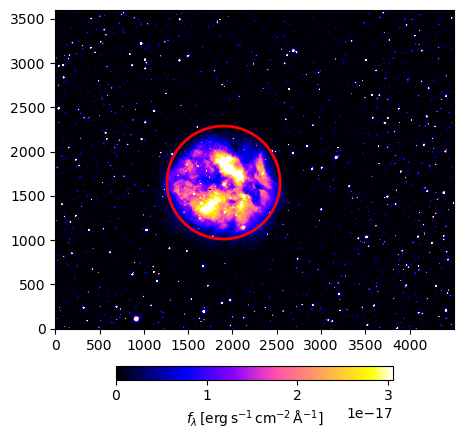

In [42]:

im = plt.imshow(images_calib['Ha'], clim=[0,np.quantile(images_calib['Ha'], 0.99)], cmap=filter_cmap['Ha'] , origin='lower')
plt.colorbar(im, location='bottom', fraction=0.0375, pad=0.1, label="$f_\\lambda \\, [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, \u00c5^{-1}}]$")

from matplotlib.patches import Circle

circle = Circle((1900,1650), radius = R_stromgen_detector, color='red', fill=False, linewidth=2)
plt.gca().add_patch(circle)  # Add the circle to the current axes



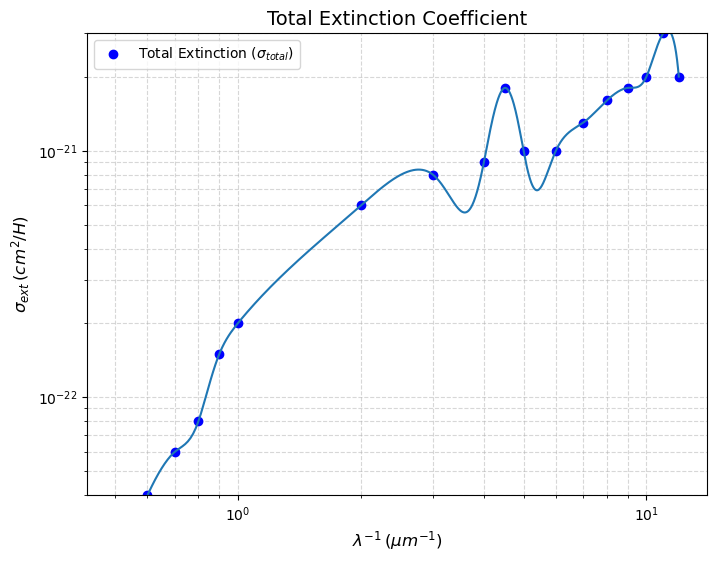

In [23]:
from scipy.interpolate import interp1d

# File format: lambda^-1 sigma_total
data = np.loadtxt("dust_extinction_curve.txt", unpack=True)
lambda_inv, sigma_total = data  # Unpack the columns


# Interpolation: Create an interpolating function
sigma_nu = interp1d(lambda_inv, sigma_total, kind="cubic")  # Cubic interpolation

plt.figure(figsize=(8, 6))
plt.plot(lambda_inv, sigma_total, label="Total Extinction ($\sigma_{total}$)", marker="o", linestyle="", color="blue")
w = np.linspace(min(lambda_inv), max(lambda_inv), 1000)
plt.plot(w,sigma_nu(w))


plt.ylim(4e-23,3e-21)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$\\lambda^{-1} \\, (\\mu m^{-1})$", fontsize=12)
plt.ylabel("$\\sigma_{ext} \\, (cm^2 / H)$", fontsize=12)
plt.title("Total Extinction Coefficient", fontsize=14)
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)

# Show the plot
plt.show()


In [ ]:
# takes lambda^-1

def tau_nu(lambda_inv,dust_H_ratio,N_H):
    return sigma_nu(lambda_inv) * dust_H_ratio * N_H
    

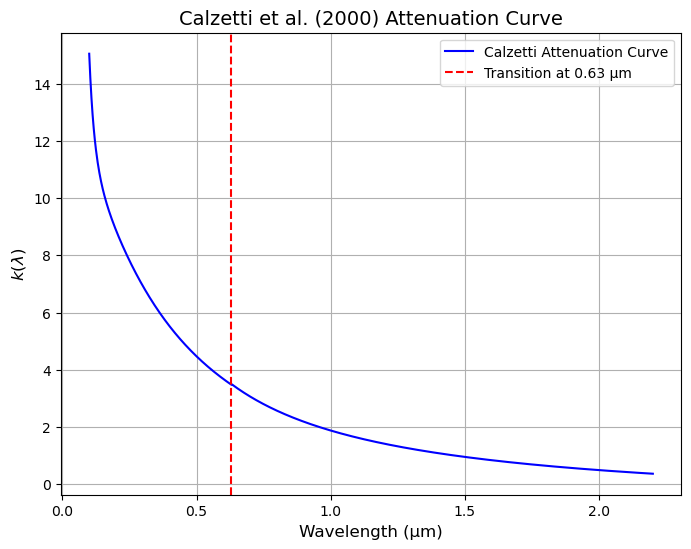

In [24]:
def calzetti_k_lambda(wavelength, R_V=4.05):
    """
    Calculate the Calzetti attenuation curve k(lambda).
    
    Parameters:
    - wavelength: Wavelength in microns (array or scalar).
    - R_V: Total-to-selective extinction ratio (default 4.05).
    
    Returns:
    - k_lambda: Attenuation curve at the given wavelengths.
    """
    wavelength = np.array(wavelength)
    k_lambda = np.zeros_like(wavelength)
    
    # UV regime: λ <= 0.63 μm
    uv_mask = wavelength <= 0.63
    k_lambda[uv_mask] = (
        2.659 * (-2.156 + 1.509 / wavelength[uv_mask] 
                 - 0.198 / wavelength[uv_mask]**2 
                 + 0.011 / wavelength[uv_mask]**3) + R_V
    )
    
    # Optical/NIR regime: λ > 0.63 μm
    optical_mask = wavelength > 0.63
    k_lambda[optical_mask] = (
        2.659 * (-1.857 + 1.040 / wavelength[optical_mask]) + R_V
    )
    
    return k_lambda

# Define wavelength range
wavelengths = np.linspace(0.1, 2.2, 1000)  # 0.1 μm to 2.2 μm
k_values = calzetti_k_lambda(wavelengths)

# Plot the curve
plt.figure(figsize=(8, 6))
plt.plot(wavelengths, k_values, label="Calzetti Attenuation Curve", color="blue")
plt.axvline(0.63, color="red", linestyle="--", label="Transition at 0.63 μm")
plt.xlabel("Wavelength (μm)", fontsize=12)
plt.ylabel("$k(\\lambda)$", fontsize=12)
plt.title("Calzetti et al. (2000) Attenuation Curve", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()
